In [19]:
%matplotlib inline


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import xbout
import scipy
import xhermes

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

from hermes3.utils import *

import gridtools.solps_python_scripts.setup
from gridtools.solps_python_scripts.utilities.last10s       import read_last10s

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.selectors import *

from code_comparison.code_comparison import *
from code_comparison.solps_pp import *
from code_comparison.viewer_2d import *
from soledge.wrapper_class import SOLEDGEcase

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

%load_ext autoreload
%autoreload 2

plt.close("all")
%matplotlib inline

print("Done")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Done


In [2]:
db = CaseDB()

toload = [ 
    dict(name="1e19", id="d45a-d42acb_1e19", unnormalise_geom = True, use_xhermes = True, squash = True), 
    dict(name="2e19", id="d42acb-with_guards", unnormalise_geom = True, use_xhermes = True, squash = True), 
    dict(name="3e19", id="d44a-d42acb_3e19", unnormalise_geom = True, use_xhermes = True, squash = True), 
    dict(name="2e19_lores", id="t9b-nonortho_xpoint_afn", unnormalise_geom = True, use_xhermes = True, squash = True), 

]
cs = {}
for case in toload:
    cs[case["name"]] = db.load_case_2D(case["id"], use_squash = case["squash"], verbose = True)
    cs[case["name"]].extract_2d_tokamak_geometry()


- Reading case d45a-d42acb_1e19
-----------------------
- Looking for squash file
- Squash file found. squash date 09/10/2024, 15:25:51, dmp file date 09/10/2024, 12:44:06


c:\Users\mikek\pyenvs\fusion-3.13\Lib\site-packages\xbout\load.py:1124: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(



Unnormalising with xHermes
- Reading case d42acb-with_guards
-----------------------
- Looking for squash file
- Squash file found. squash date 09/03/2024, 10:49:23, dmp file date 09/03/2024, 10:28:10


c:\Users\mikek\pyenvs\fusion-3.13\Lib\site-packages\xbout\load.py:1124: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(



Unnormalising with xHermes
- Reading case d44a-d42acb_3e19
-----------------------
- Looking for squash file
- Squash file found. squash date 09/10/2024, 15:27:45, dmp file date 09/10/2024, 12:48:53


c:\Users\mikek\pyenvs\fusion-3.13\Lib\site-packages\xbout\load.py:1124: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(



Unnormalising with xHermes
- Reading case t9b-nonortho_xpoint_afn
-----------------------
- Looking for squash file
- Squash file found. squash date 09/03/2024, 14:20:48, dmp file date 09/03/2024, 12:28:50


c:\Users\mikek\pyenvs\fusion-3.13\Lib\site-packages\xbout\load.py:1124: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(



Unnormalising with xHermes


# Read SOLEDGE

In [3]:
soledgecases = {
    "tightwall_1e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_1e19"), # Hermes-3 like wall
    "tightwall_2e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_2e19"), # Hermes-3 like wall
    # "widewall_2e19_5m" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_2e19_5M"),
    "tightwall_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_3e19"), # Hermes-3 like wall
    # "widewall_1e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_1e19"), 
    # "widewall_2e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_2e19"), 
    # "widewall_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_3e19"), 
}

sl = dict()

for name in soledgecases:
    print(name)
    path = soledgecases[name]
    sl[name] = SOLEDGEdata(path = path)
    sl[name].read_csv(os.path.join(path, "omp_plasma.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "omp_neutrals.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "imp_plasma.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "imp_neutrals.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "wall_ntmpi_plasma.csv"), mode = "wall_ntmpi")

## Make sure M is always positive
for region in ['inner_lower', 'outer_lower', 'outer_upper', 'inner_upper']:
    for name in soledgecases:
        sl[name].regions[region]["M"] = np.abs(sl[name].regions[region]["M"])


tightwall_1e19
tightwall_2e19
tightwall_3e19


# Read SOLPS

In [4]:
solpscases = {

    # "tightwall_noD2_1e19_novisc" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_novisc\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=1.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0",
    # "tightwall_noD2_2e19_novisc" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_novisc\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=2.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0",
    # "tightwall_noD2_3e19_novisc" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_novisc\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=3.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0",
    # "tightwall_noD2_1e19_novisc_spectra" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_novisc_spectra\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=1.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0",
    # "tightwall_noD2_2e19_novisc_spectra" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_novisc_spectra\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=2.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0",
    # "tightwall_noD2_3e19_novisc_spectra" : r"C:\Users\mikek\OneDrive\Project\collab\From\Matteo\2024-11-01 - 1e19 2e19 3e19 no viscosity, spectra\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_spectra_20241106\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=3.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0",
    # "tightwall_noD2_1e19_fixpuff" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playArounD_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_novisc_fixpuff\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=1.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0",
    # "tightwall_noD2_2e19_fixpuff" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playArounD_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_novisc_fixpuff\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=2.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0",
    # "tightwall_noD2_3e19_fixpuff" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playArounD_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_novisc_fixpuff\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=3.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0",
    "tightwall_noD2_1e19_zerophi" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_zero_phi\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=1.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0.b2news_poteq=0",
    "tightwall_noD2_2e19_zerophi" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_zero_phi\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=2.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0.b2news_poteq=0",
    "tightwall_noD2_3e19_zerophi" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_zero_phi\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=3.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0.b2news_poteq=0",
    
    "tightwall_noD2_1e19_zerophi_spectra" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_zero_phi\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=1.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0.b2news_poteq=0",
    "tightwall_noD2_2e19_zerophi_spectra" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_zero_phi\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=2.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0.b2news_poteq=0",
    "tightwall_noD2_3e19_zerophi_spectra" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_zero_phi\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=3.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0.b2news_poteq=0",
    
    # "base" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5"),
    # "noiz_core" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16"),
    # "gammai_2.5" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.GAMMAI=2.5E+00"),
    # "dpuff_1e22" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=1.0E+22"),
    # "dpuff_5e21" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=5.0E+21"),
    # "no_fast_reflec" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.Pf=0"),
    # "nsep_2e19" : os.path.join(onedrive_path,r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=2E+19"),
    # "nsep_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=3E+19"),
    # "narrow_core" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent"),
    # "no_visc" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent.b2tqca_phm0=0"),
    
    # "core_extent_16x_mc" : os.path.join(onedrive_path, r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.xxx.BCCON=16.core_extent.MC.histories.x16-ish.NOT.converged"),
    # "widewall_2e19" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=2E+19",
    # "tightwall_2e19" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_MK\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.NESEPM=2.0E+19",
    # "tightwall_3e19" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_MK\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.NESEPM=3.0E+19",
    # "tightwall_noD2_1e19" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_MK\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.NESEPM=1.0E+19.NO.D2",
    # "tightwall_noD2_2e19" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_MK\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.NESEPM=2.0E+19.NO.D2",
    # "tightwall_noD2_3e19" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_MK\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.NESEPM=3.0E+19.NO.D2",
    
}

sp = dict()

for name in solpscases:
    sp[name] = SOLPSdata()
    # _ = read_last10s(solpscases[name], save = True)
    # sp[name].read_last10s(solpscases[name])
    sp[name].read_from_case(solpscases[name])

# Read Hermes-3

In [5]:
cs.keys()

dict_keys(['1e19', '2e19', '3e19', '2e19_lores'])

In [8]:
hr = dict()
for name in cs.keys(): 
    print(name)
    hr[name] = Hermesdata()
    ds = cs[name].ds
    if "t" in ds.dims: ds = ds.isel(t=-1)
    hr[name].read_case(ds)

    
    ds = cs[name].ds
    # ds = calculate_radial_fluxes(ds, new_afn = True)
    # ds = calculate_target_fluxes(ds)
    # ds = reverse_pfr_fluxes(ds)

1e19
2e19
3e19
2e19_lores


# Convergence

In [ ]:
case = "no_fastrec_tune"
lineplot(
    {
        # "start":cs[case].ds.isel(t=0, x = slice(2,-2)),
        # "-5":cs[case].ds.isel(t=-3, x = slice(2,-2)),
        "last":cs[case].ds.isel(t=-1, x = slice(2,-2)),
        # "base":cs["base"].ds.isel(t=-1, x = slice(2,-2)),

    },
    clean_guards = False,
    params = ["Te", "Td+", "Td", "Ne", "Nd"],
    regions = ["omp", "outer_lower", "field_line"],
)

KeyError: 'no_fastrec_tune'

: 

In [ ]:
cases = { 

    "SOLPS, no D2, no viscosity" : dict(data=sp["tightwall_noD2_1e19_novisc_spectra"], color="deeppink"),
    "SOLEDGE2D" : dict(data=sl["tightwall_1e19"], color="black"),
    r"Hermes-3: max_mfp=1, cond_alpha=0.25" : dict(data=hr['1e19'], color = "teal"),


    },

# New rebaseline - no viscosity, zero phi

## Pressures

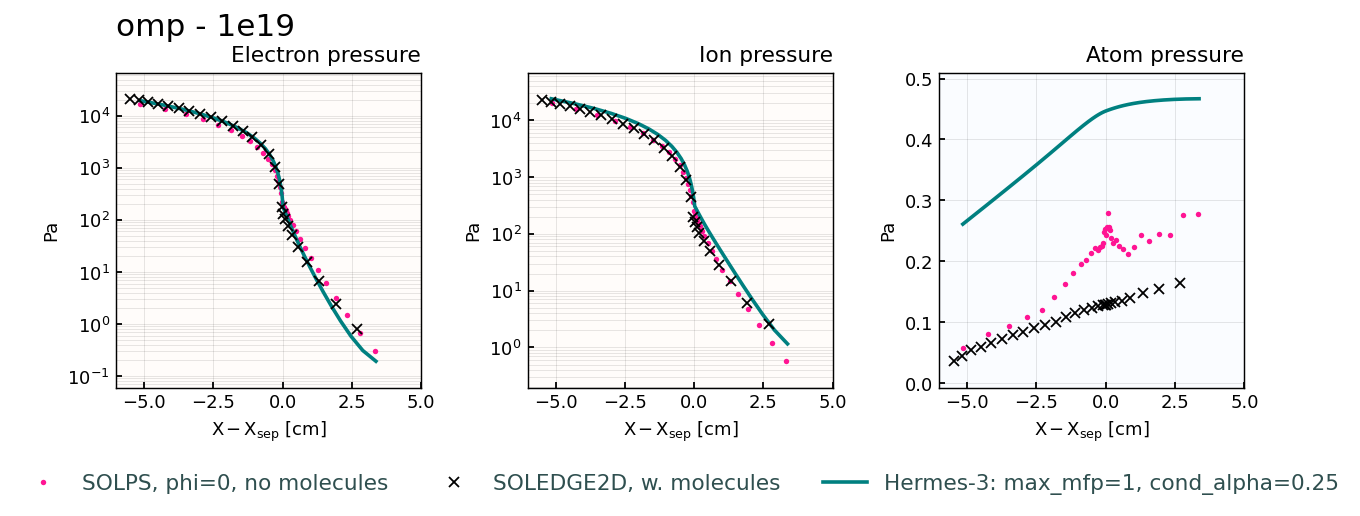

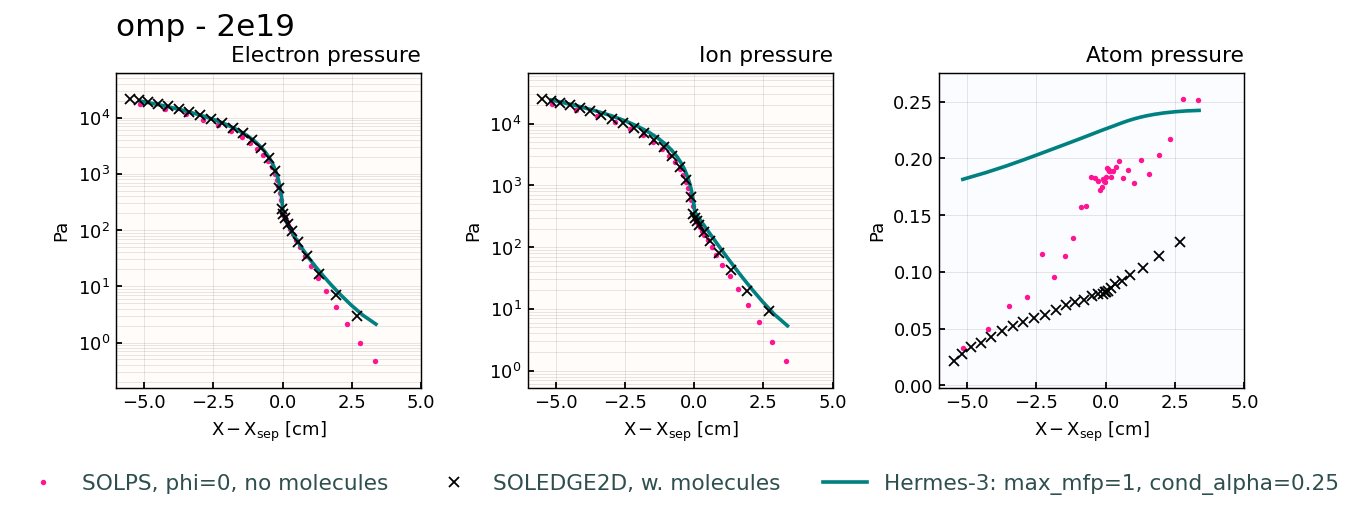

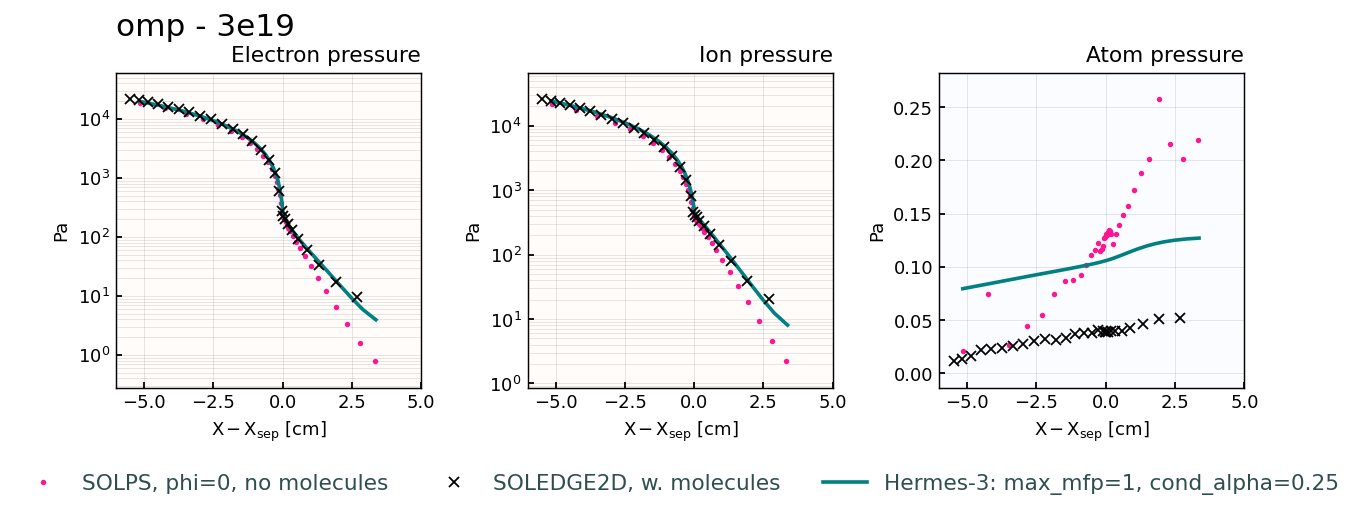

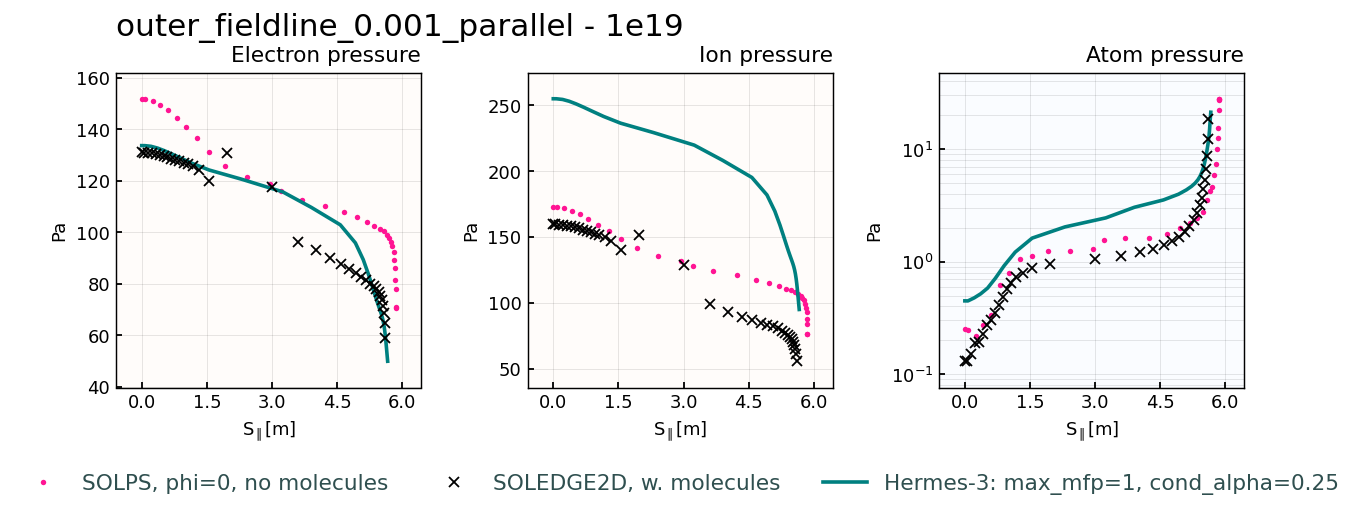

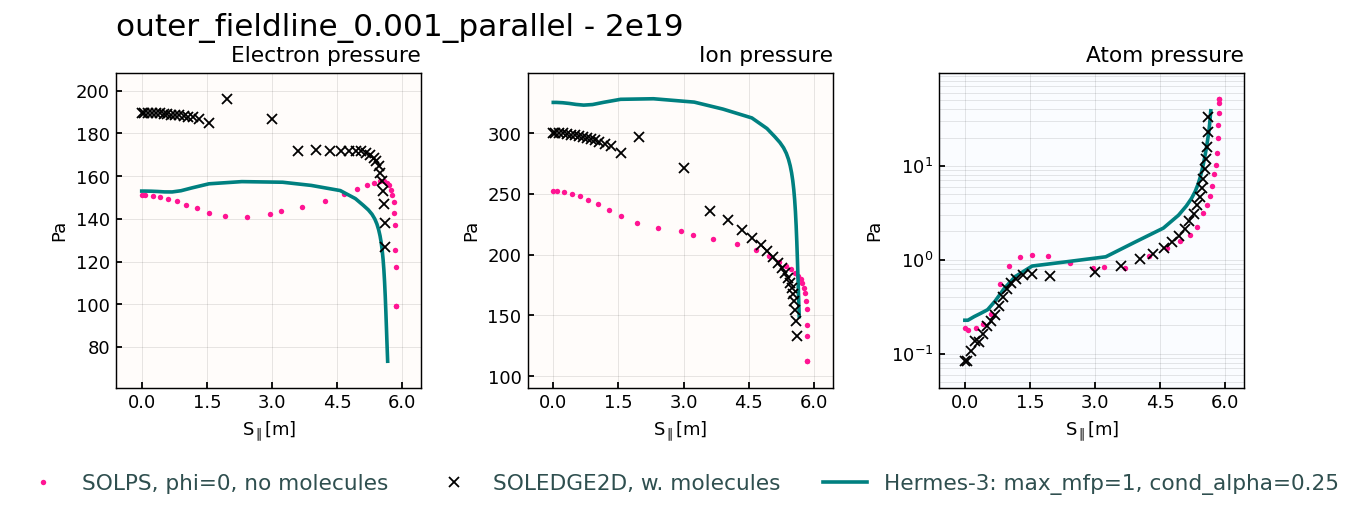

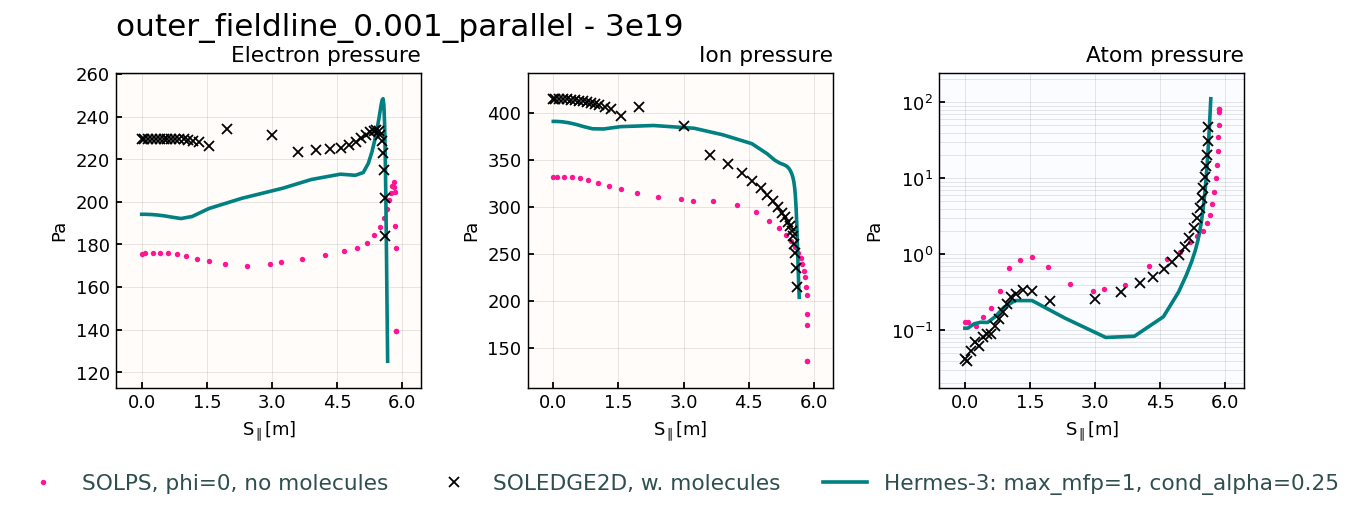

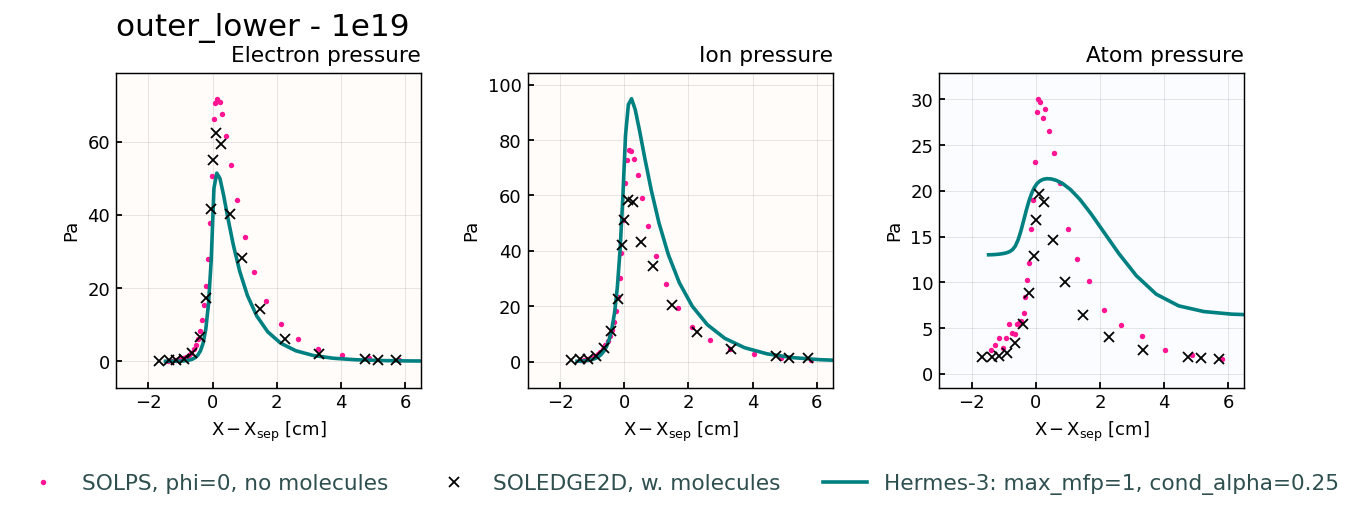

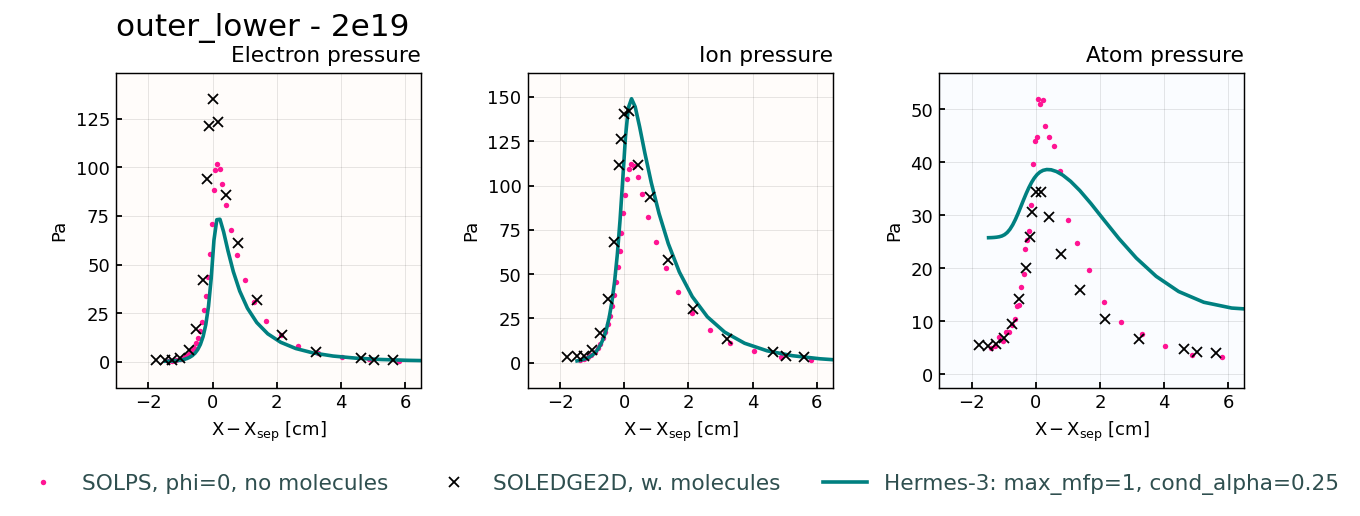

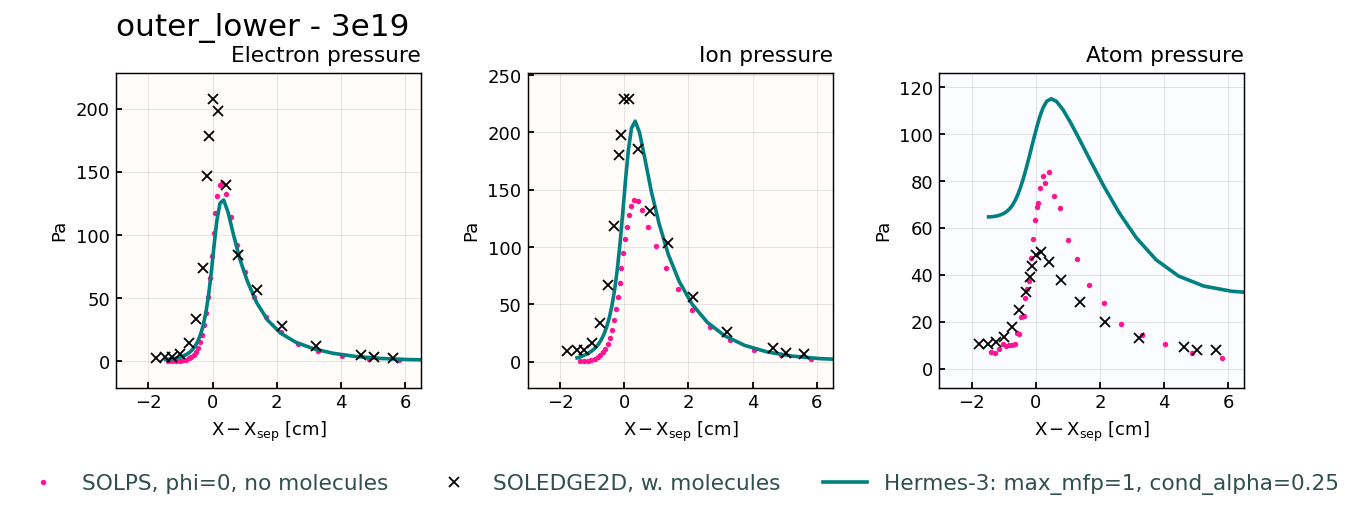

In [ ]:
               
plot_by_region(
    cases = { 

        "SOLPS, phi=0, no molecules" : dict(name="tightwall_noD2_1e19_zerophi", color="deeppink"),
        "SOLEDGE2D, w. molecules" : dict(name="tightwall_1e19", color="black"),
        r"Hermes-3: max_mfp=1, cond_alpha=0.25" : dict(name='1e19', color = "teal"),

    },
    regions = ["omp", "outer_fieldline_0.001_parallel", "outer_lower"],
    # params = ["Ne", "Te", "Td+", "Na", "Ta", "M"],
    params = ["Pe", "Pd+", "Pa"],
    # params = ["Nn", "Na", "Nm", "Pn", "Pa", "Pm", "Tn", "Ta", "Tm"],
    data_dicts = {"SOLPS":sp, "SOLEDGE2D":sl, "Hermes-3":hr},
    dpi = 100,
    ylims = (5e17, 2e20),
    lw = 2,
    legend_nrows =1,
    combine_molecules = False)

## Temperatures, densities

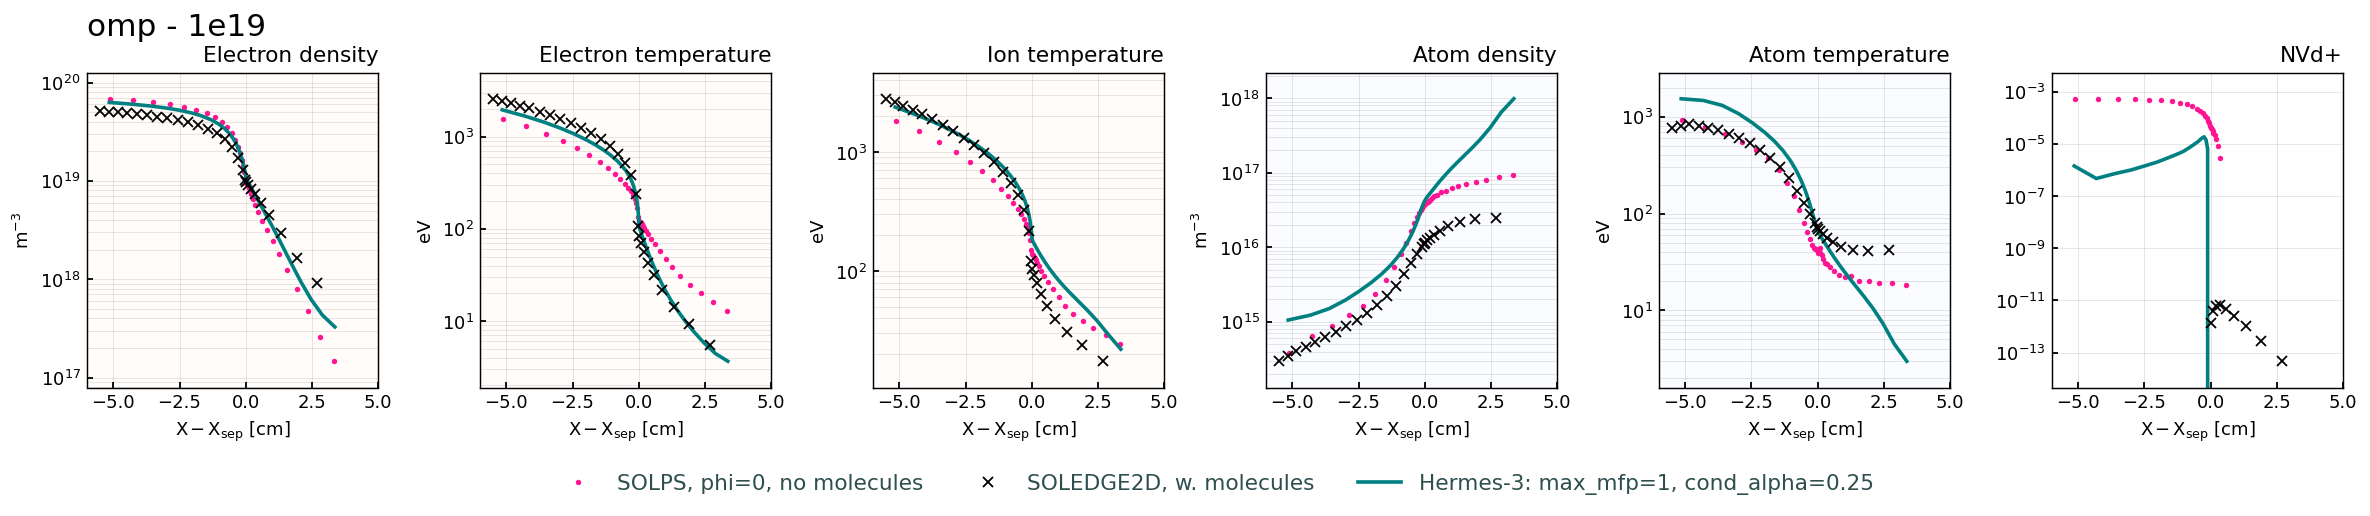

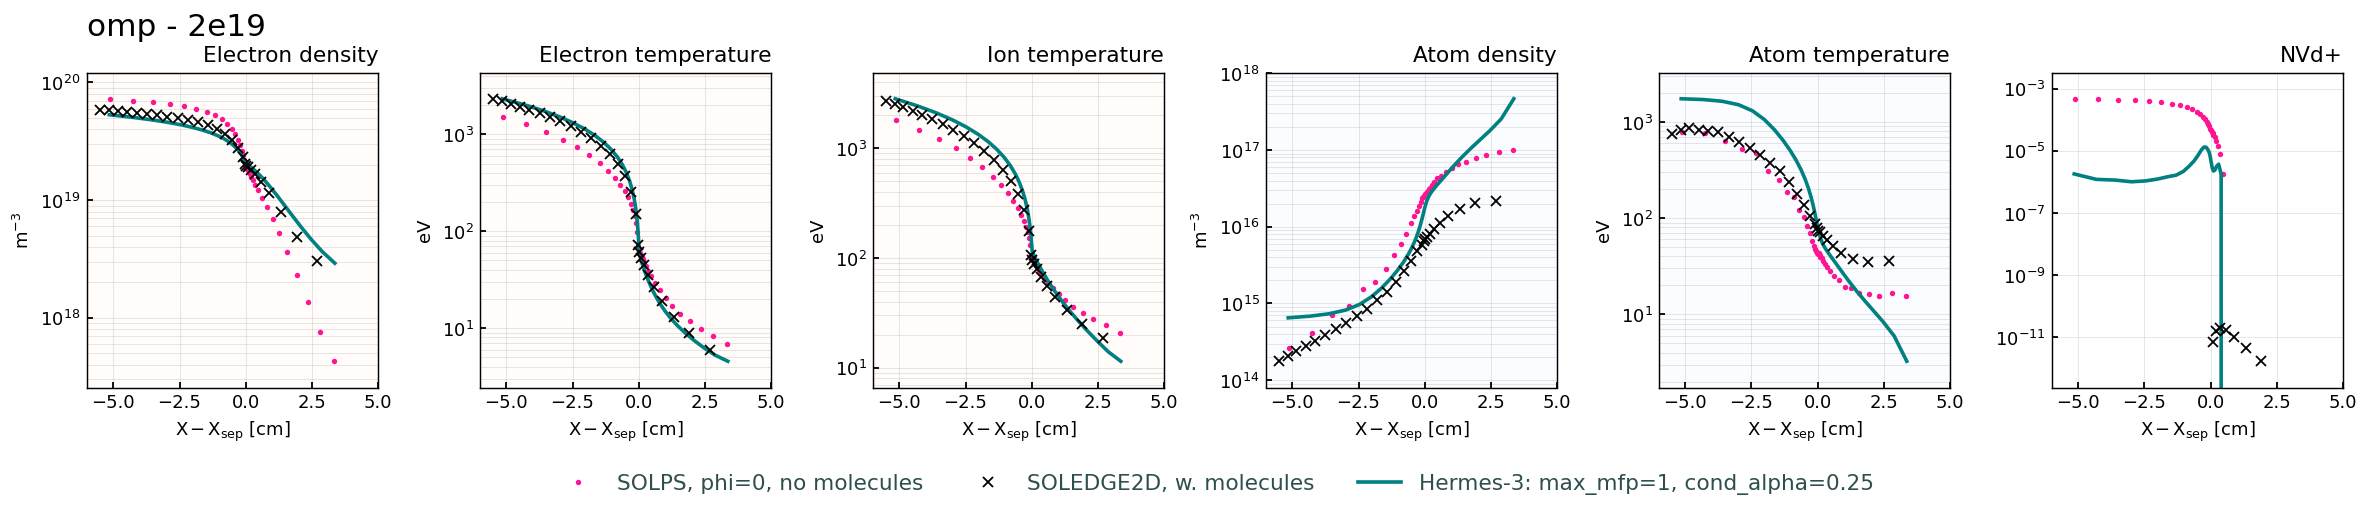

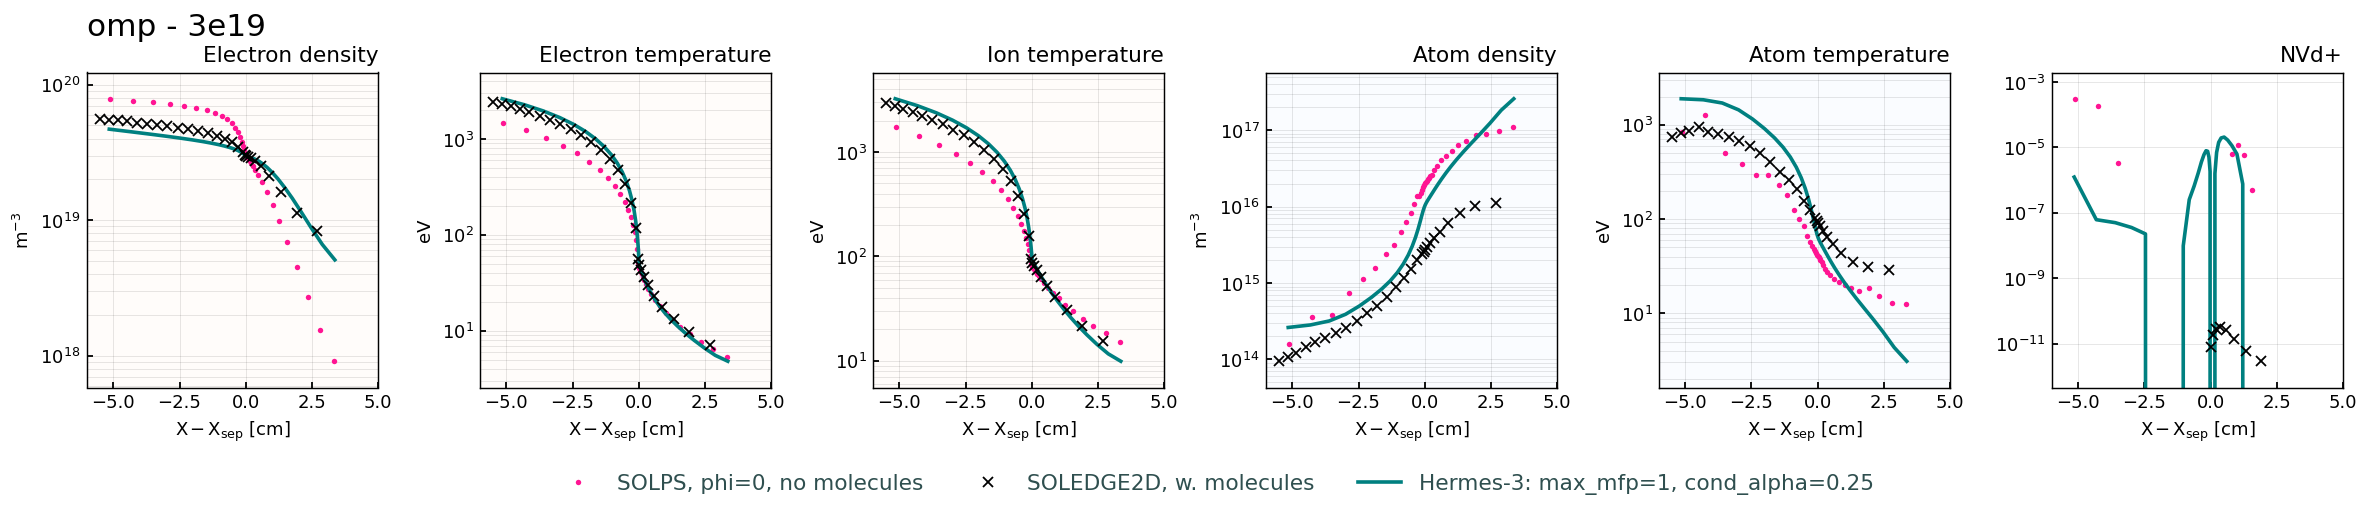

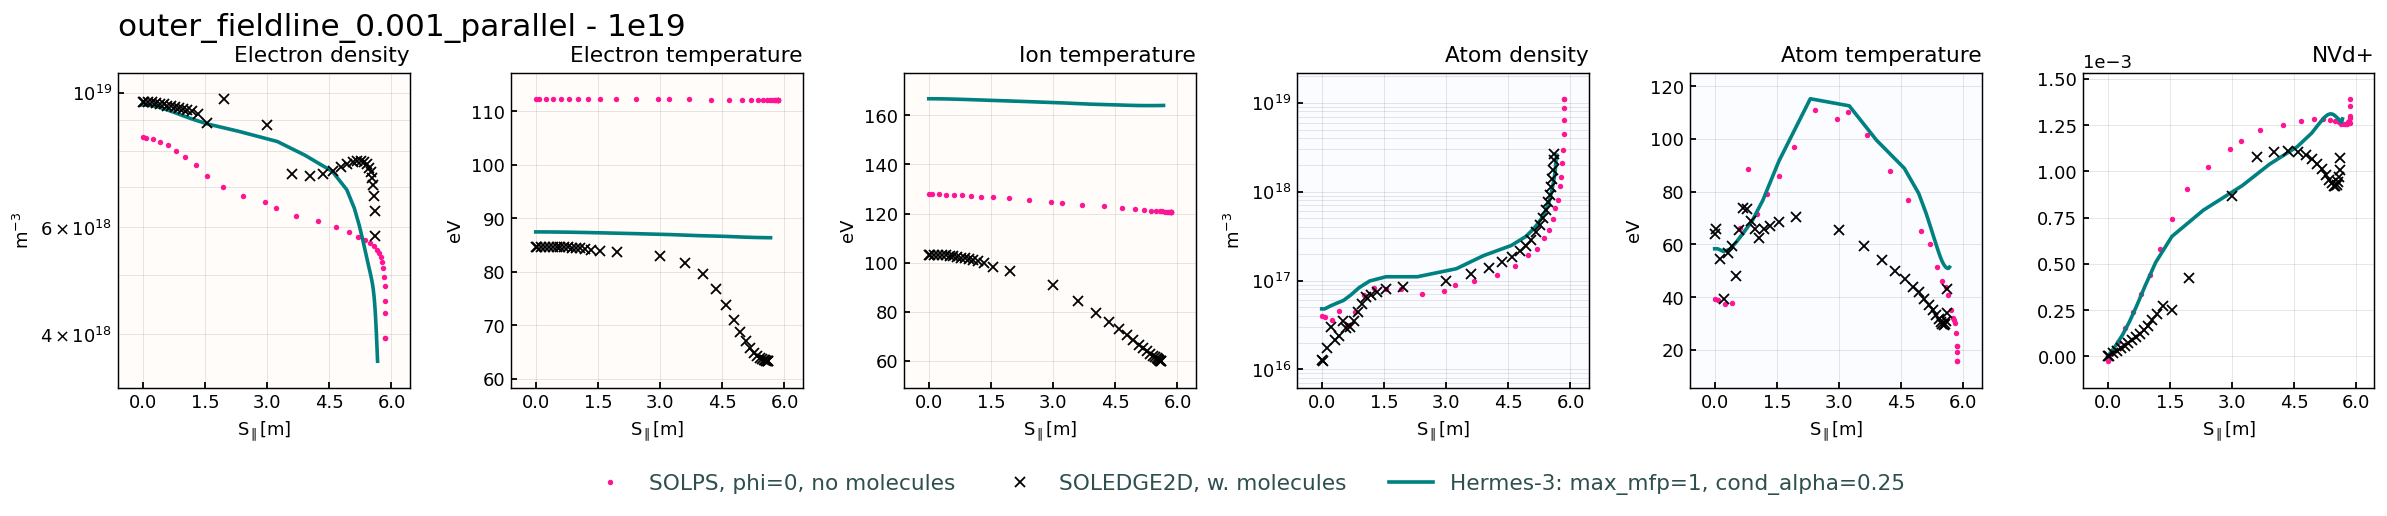

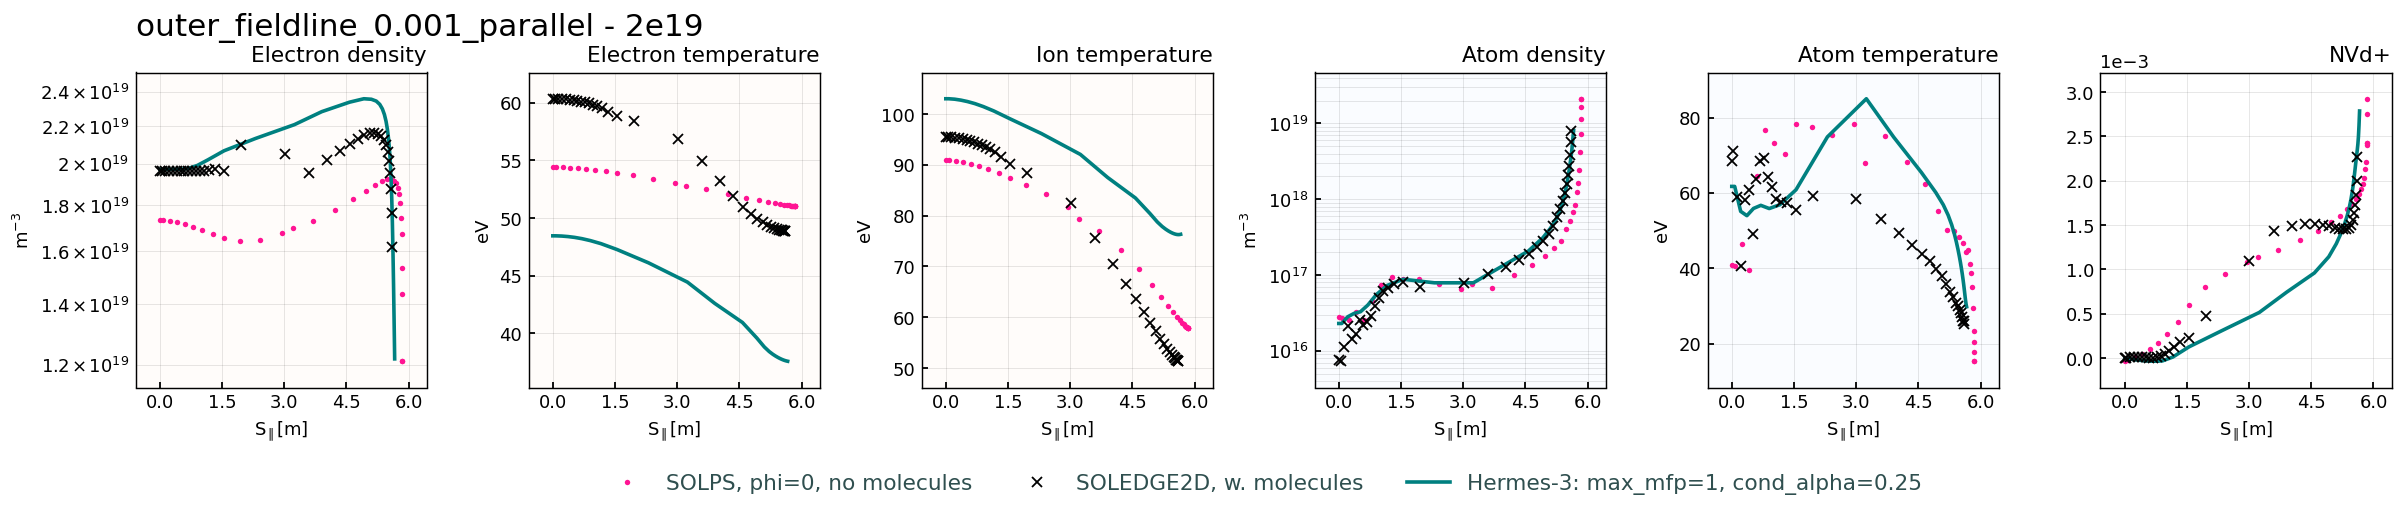

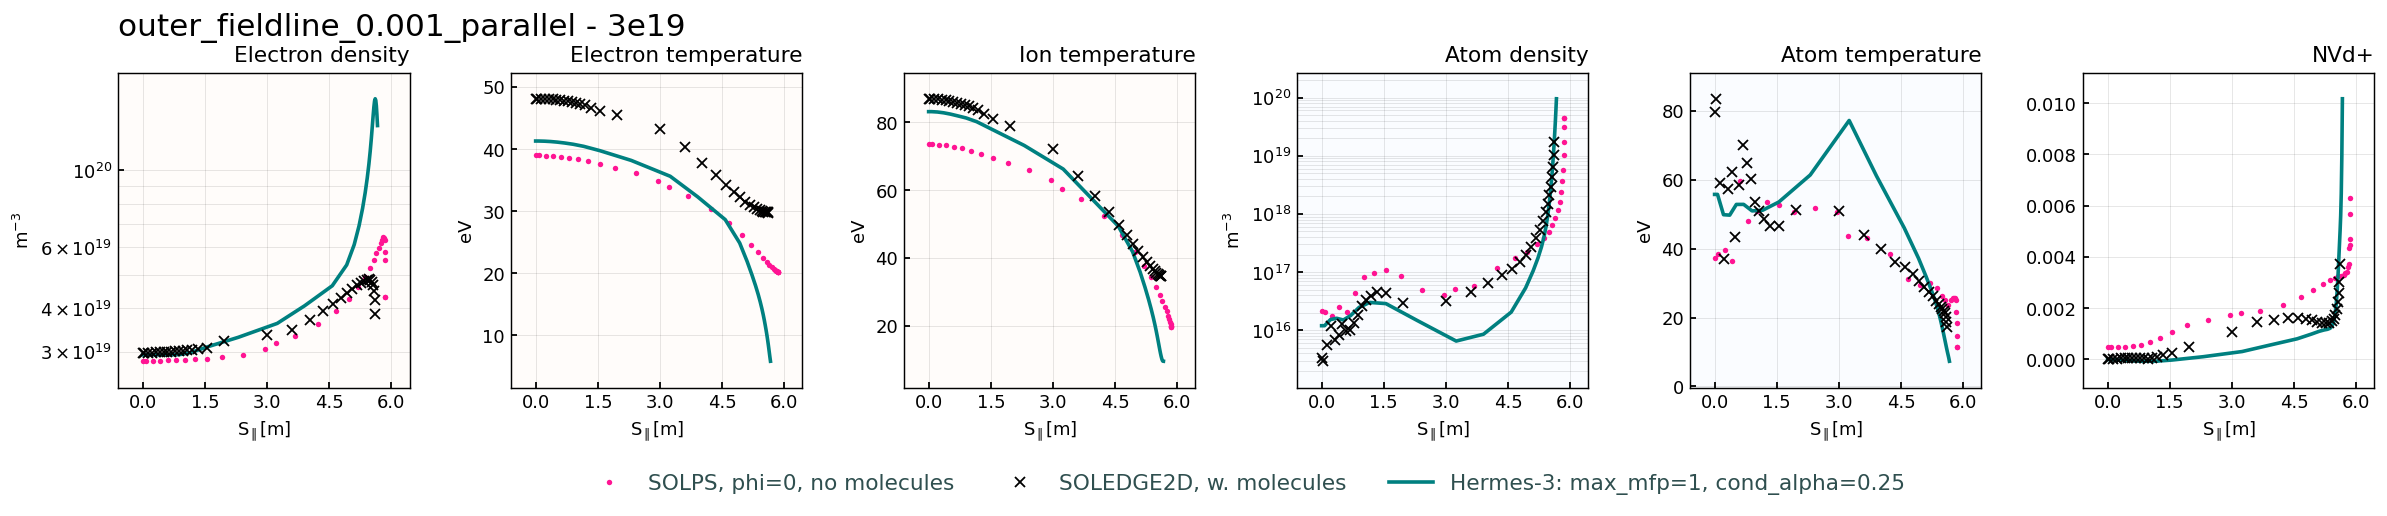

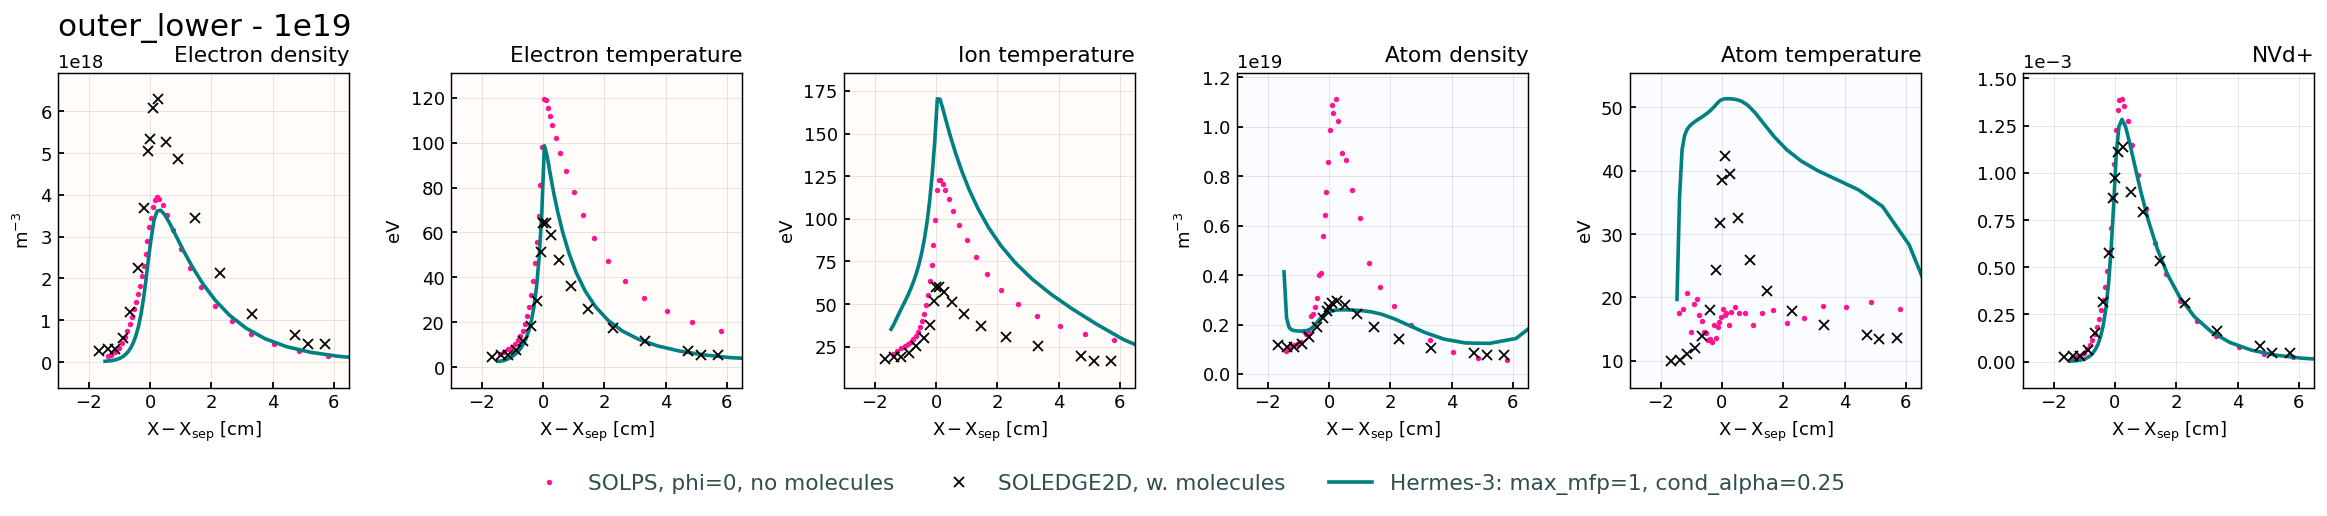

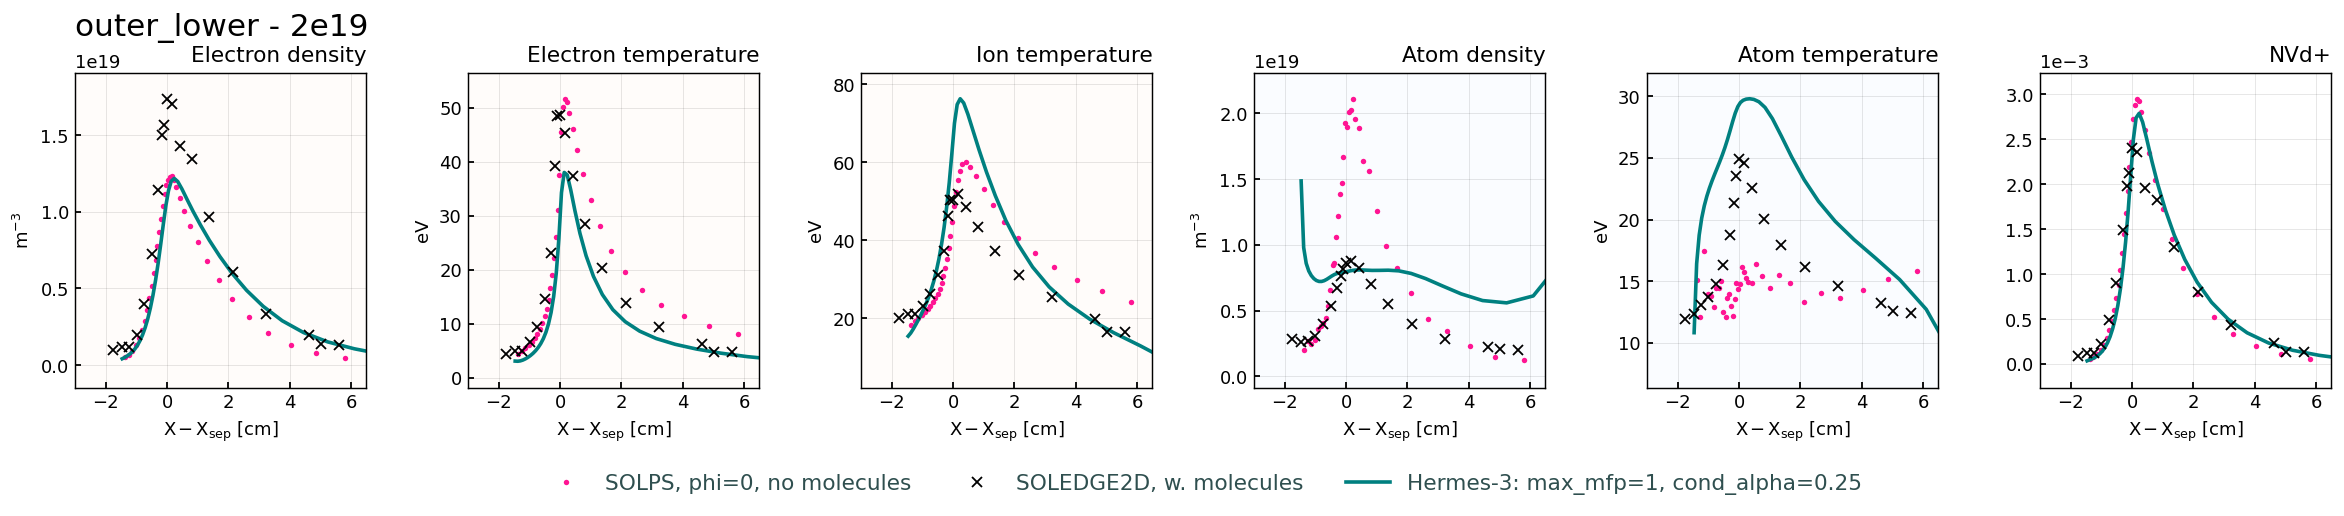

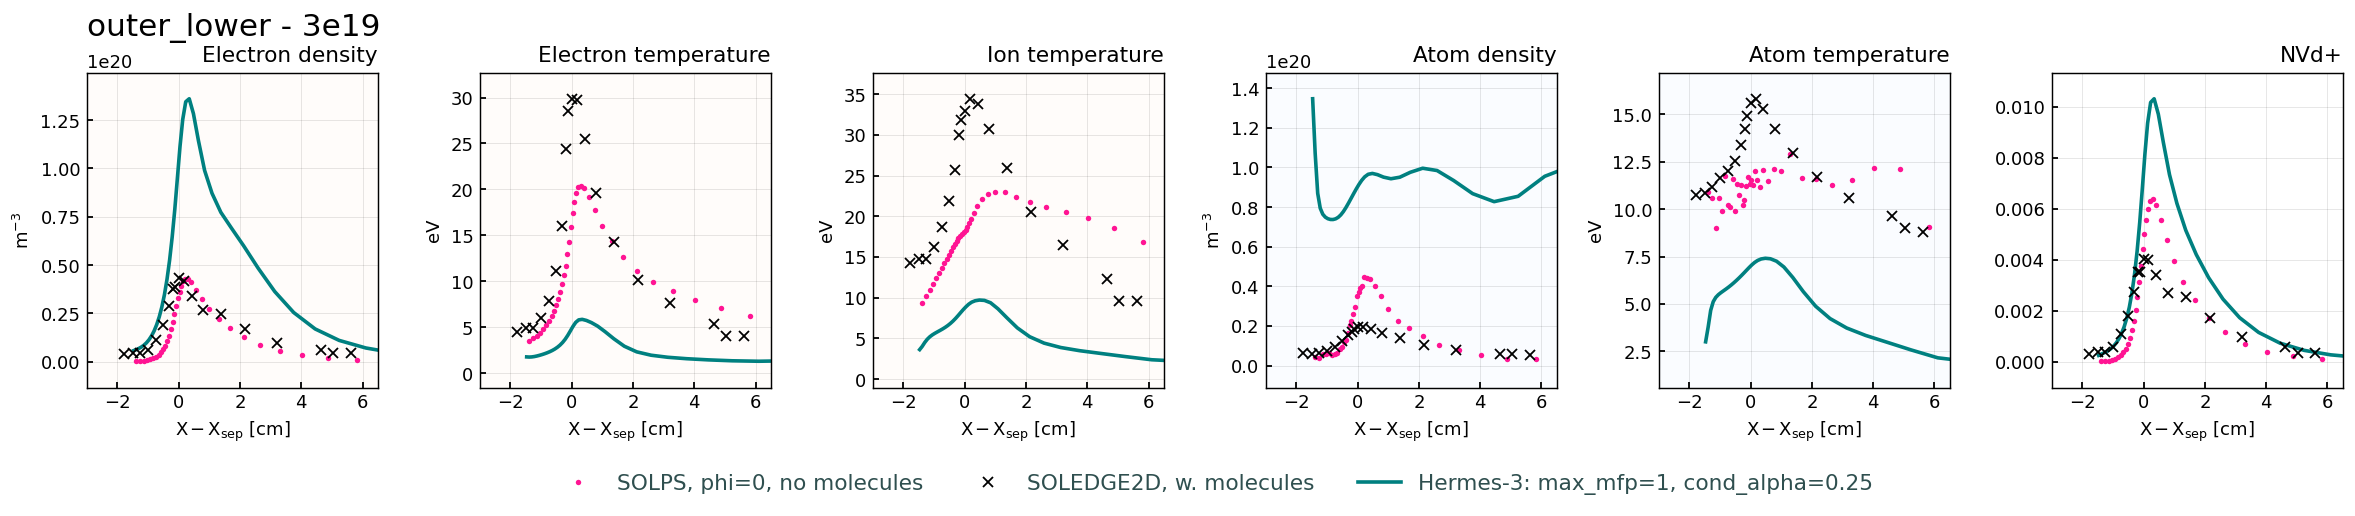

In [65]:
               
plot_by_region(
    cases = { 

        "SOLPS, phi=0, no molecules" : dict(name="tightwall_noD2_1e19_zerophi", color="deeppink"),
        "SOLEDGE2D, w. molecules" : dict(name="tightwall_1e19", color="black"),
        r"Hermes-3: max_mfp=1, cond_alpha=0.25" : dict(name='1e19', color = "teal"),

    },
    regions = ["omp", "outer_fieldline_0.001_parallel", "outer_lower"],
    params = ["Ne", "Te", "Td+", "Na", "Ta", "NVd+"],
    # params = ["Pe", "Pd+", "Pa"],
    # params = ["Nn", "Na", "Nm", "Pn", "Pa", "Pm", "Tn", "Ta", "Tm"],
    data_dicts = {"SOLPS":sp, "SOLEDGE2D":sl, "Hermes-3":hr},
    dpi = 100,
    ylims = (5e17, 2e20),
    lw = 2,
    legend_nrows =1,
    combine_molecules = False)

# Lores case check

In [7]:
cs.keys()

dict_keys(['1e19', '2e19', '3e19', '2e19_lores'])

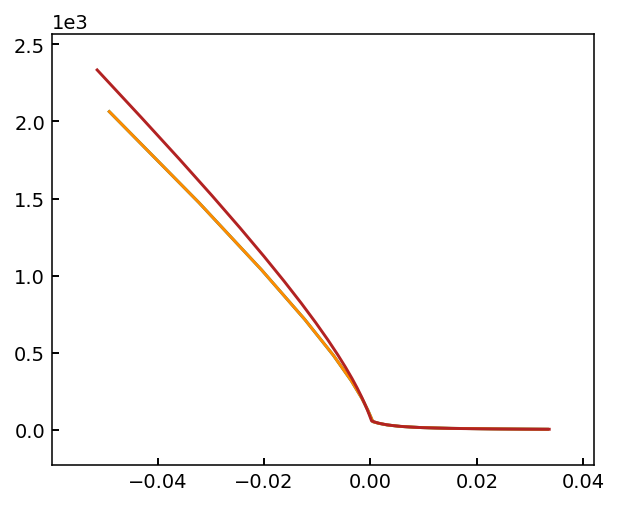

In [28]:
df = hr['2e19_lores'].regions["omp"]
df2 = get_1d_radial_data_old(cs["2e19_lores"].ds.isel(t=-1), ["Te", "Ne"], region = "omp")
df3 = hr["2e19"].regions["omp"]

fig, ax = plt.subplots()
ax.plot(df.index, df["Te"], label = "Old")
ax.plot(df2["Srad"], df2["Te"], label = "new")
ax.plot(df3.index, df3["Te"], label = "hires")

None not available in SOLEDGE2D, omp


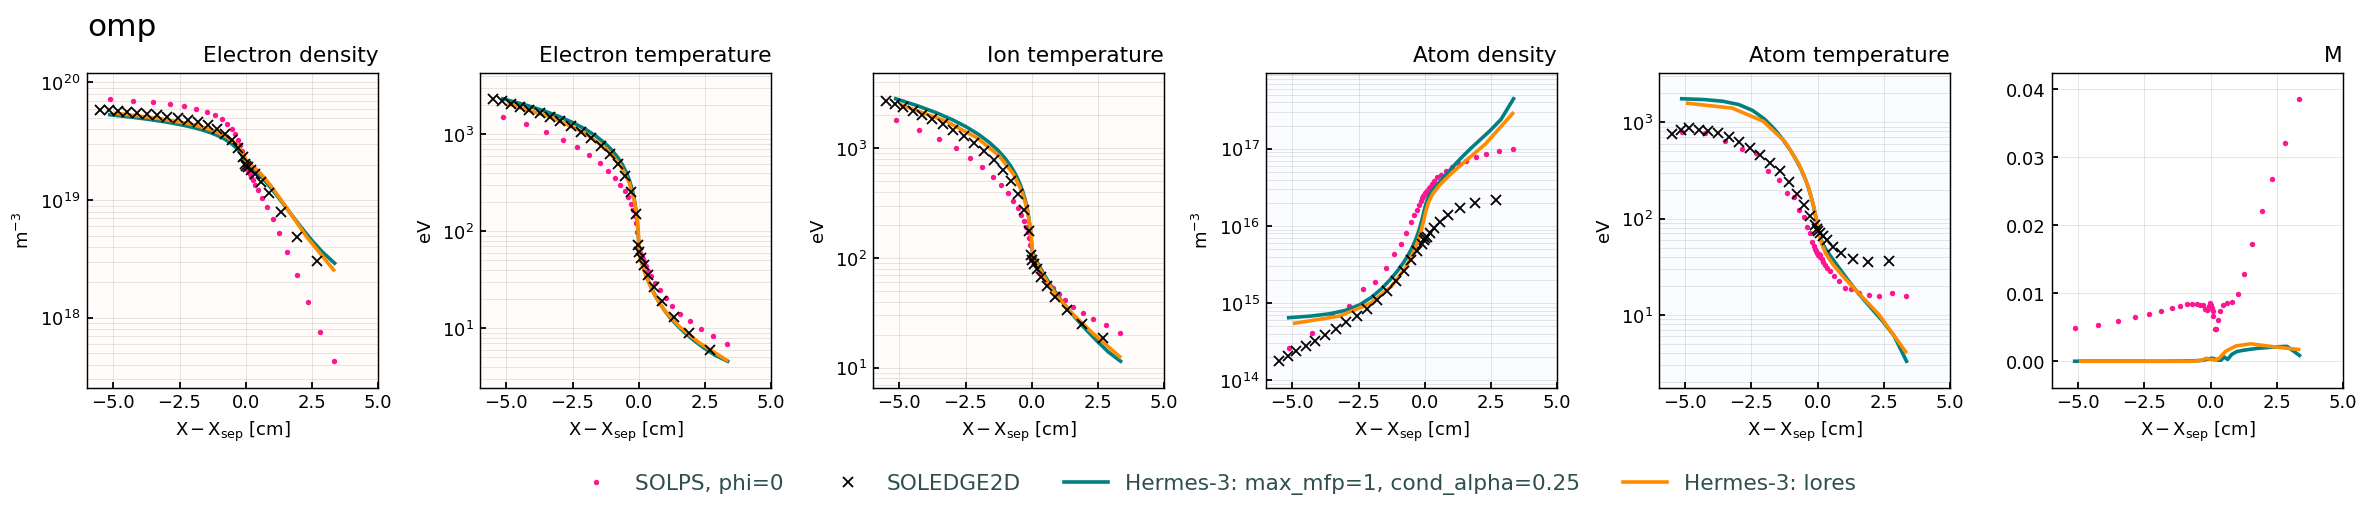

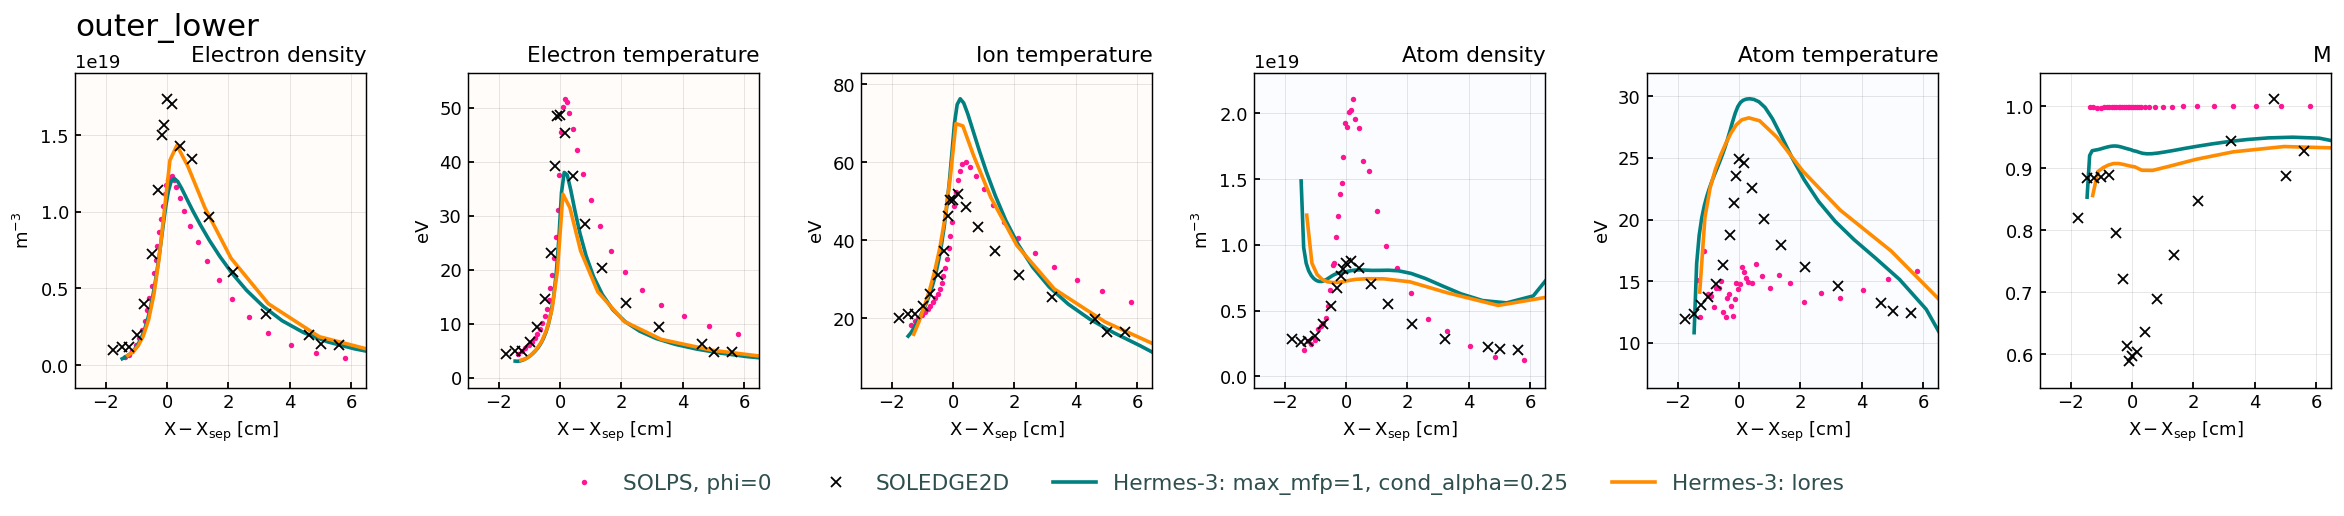

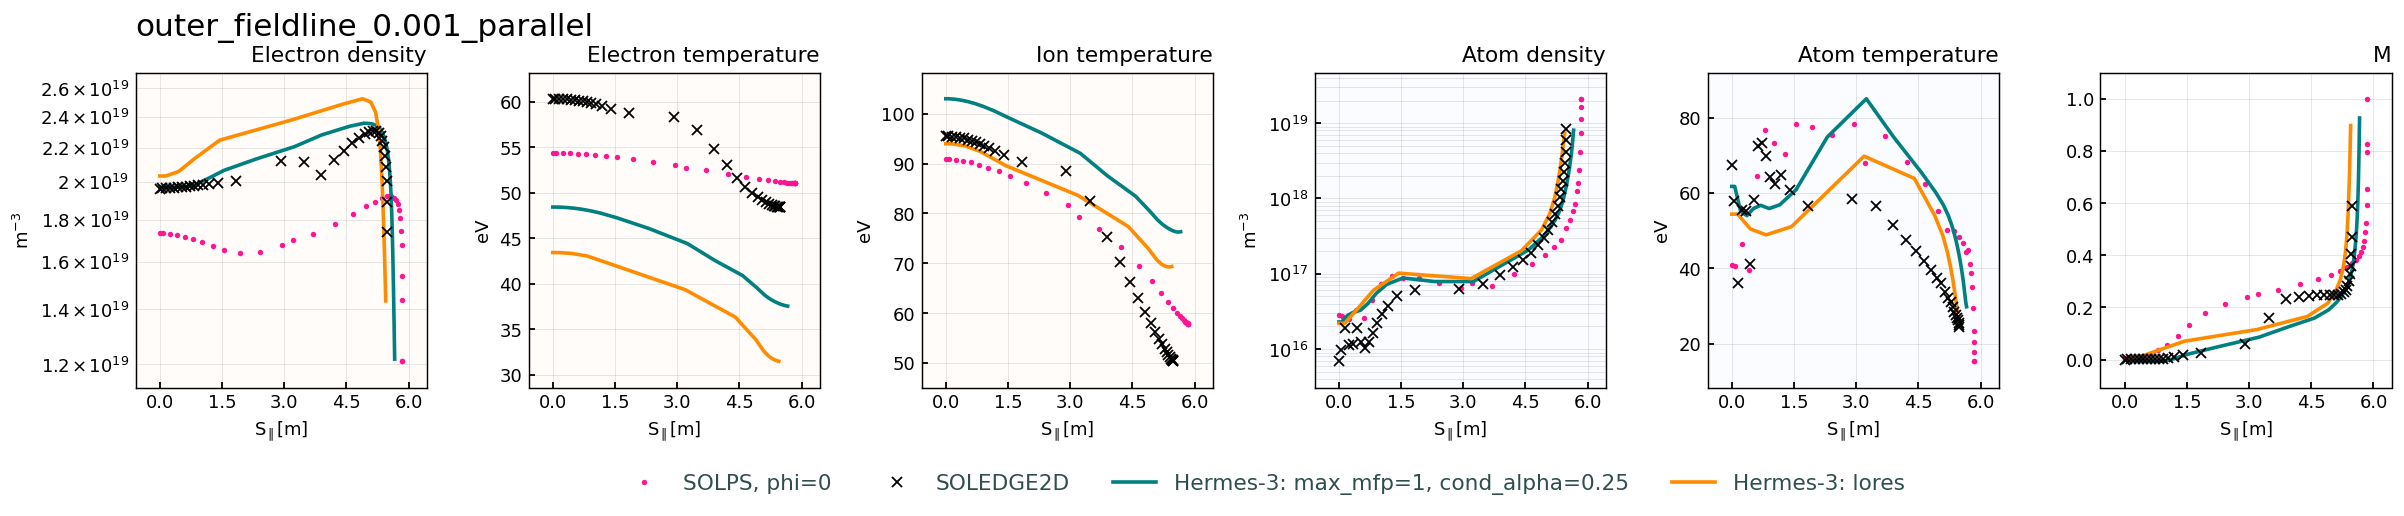

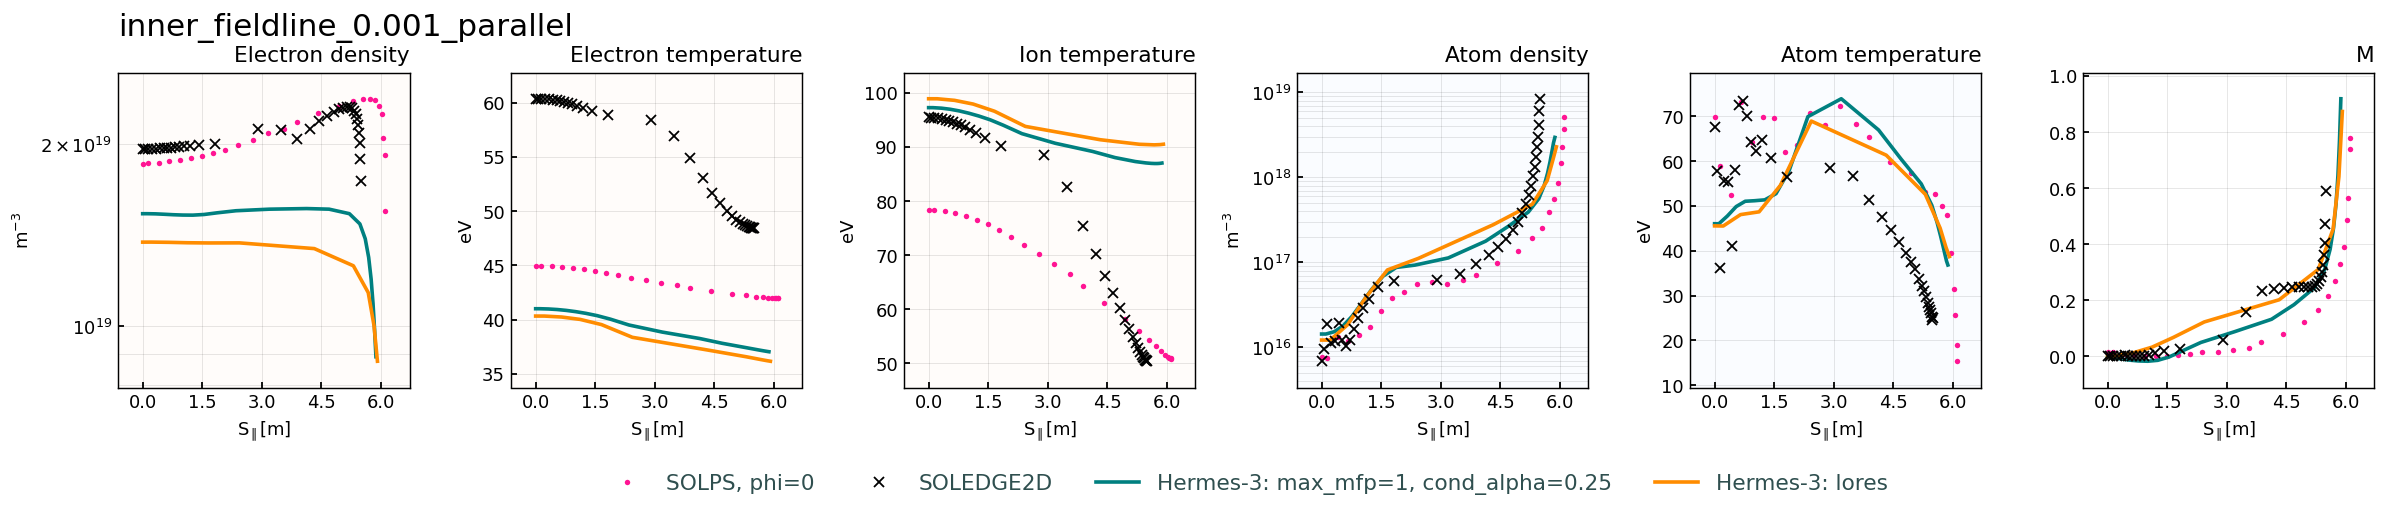

In [9]:
lineplot_compare(
    cases = { 

    "SOLPS, phi=0" : dict(data=sp["tightwall_noD2_2e19_zerophi"], color="deeppink"),
    "SOLEDGE2D" : dict(data=sl["tightwall_2e19"], color="black"),
    r"Hermes-3: max_mfp=1, cond_alpha=0.25" : dict(data=hr['2e19'], color = "teal"),
    r"Hermes-3: lores" : dict(data=hr['2e19_lores'], color = "darkorange"),

    },
    regions = [
        "omp","outer_lower", "outer_fieldline_0.001_parallel", "inner_fieldline_0.001_parallel"],  
    
    # params = ["Ne", "Te", "Td+", "NVd+", "Vd+", "M"],
    params = ["Ne", "Te", "Td+", "Na", "Ta", "M"],
    dpi = 100,
    ylims = (5e17, 2e20),
    lw = 2,
    legend_nrows =1,
    combine_molecules = False
)